## On plot ensemble les datas

In [1]:
from animate import anim 
import numpy as np
import torch 
from model import PINNs
from deepxrte.geometry import Rectangle
import pandas as pd
from utils import charge_data
import json
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
with open("results/1_first_try" + "/hyper_param.json", "r") as file:
    hyper_param = json.load(file)

model = PINNs(hyper_param)
checkpoint = torch.load('results/1_first_try/epoch3200'+'/model_weights.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [3]:
param_adim = {
    'V':2,
    'L':0.025,
    'rho': 1.2
}

In [5]:
X_train, U_train, X_full, U_full, X_border, mean_std = charge_data(hyper_param, param_adim)
X_pred = torch.tensor(X_full, dtype=torch.float32)


In [6]:
U_pred = model(X_pred)
x_norm_pred, y_norm_pred, t_norm_pred = X_pred.detach().numpy()[:,0], X_pred.detach().numpy()[:,1], X_pred.detach().numpy()[:,2]
u_norm_pred, v_norm_pred, p_norm_pred = U_pred.detach().numpy()[:,0], U_pred.detach().numpy()[:,1], U_pred.detach().numpy()[:,2]

In [7]:
x_pred = (x_norm_pred*mean_std['x_std'] + mean_std['x_mean'])*param_adim['L']
y_pred = (y_norm_pred*mean_std['y_std'] + mean_std['y_mean'])*param_adim['L']
t_pred = (t_norm_pred*mean_std['t_std'] + mean_std['t_mean'])*(param_adim['L']/param_adim['V'])
u_pred = (u_norm_pred*mean_std['u_std'] + mean_std['u_mean'])*param_adim['V']
v_pred = (v_norm_pred*mean_std['v_std'] + mean_std['v_mean'])*param_adim['V']
p_pred =( p_norm_pred*mean_std['p_std'] + mean_std['p_mean'])*((param_adim['L']**2) * param_adim['rho'])
norme_vitesse_pred = np.sqrt(u_pred**2 + v_pred**2)


In [8]:
u_data = (U_full[:,0]*mean_std['u_std'] + mean_std['u_mean'])*param_adim['V']
v_data = (U_full[:,1]*mean_std['v_std'] + mean_std['v_mean'])*param_adim['V']
p_data =( U_full[:,2]*mean_std['p_std'] + mean_std['p_mean'])*((param_adim['L']**2) * param_adim['rho'])
norme_vitesse_data = np.sqrt(u_data**2 + v_data**2)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

def plot_flow(x, y, t, norme_vitesse_data, norme_vitesse_predict, name_file, fps=7, title='Norme vitesse'):
    # Créer une figure et des axes
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # Ajuster la taille de la figure

    # Déterminer les valeurs min et max pour la colormap
    vmin = min(np.min(norme_vitesse_data), np.min(norme_vitesse_predict))
    vmax = max(np.max(norme_vitesse_data), np.max(norme_vitesse_predict))

    # Initialiser les cartes de chaleur
    indices = np.where(t == np.min(t))
    c1 = ax[0].tripcolor(x[indices],
            y[indices],
            norme_vitesse_data[indices], shading="gouraud", cmap="coolwarm", vmin=vmin, vmax=vmax)
    c2 = ax[1].tripcolor(x[indices],
            y[indices],
            norme_vitesse_predict[indices], shading="gouraud", cmap="coolwarm", vmin=vmin, vmax=vmax)

    ax[0].set_title('Données')
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    
    ax[1].set_title('Prédictions')
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")

    # Ajouter une barre de couleur
    cbar = fig.colorbar(c1, ax=ax, orientation='vertical', label=f"{title}")

    # Fonction d'initialisation
    def init():
        return c1, c2

    # Fonction d'animation
    def update(frame):
        print(frame)
        time = list(set(t))
        time.sort()
        indices = np.where(t == time[frame])
        
        # Mettre à jour la première carte de chaleur
        c1.set_array(norme_vitesse_data[indices].flatten())
        ax[0].set_title('Données')
        
        # Mettre à jour la deuxième carte de chaleur
        c2.set_array(norme_vitesse_predict[indices].flatten())
        ax[1].set_title('Prédictions')

        # Titre général
        plt.suptitle(f"{title} à t={time[frame]:.2f}", fontsize=16)

        return c1, c2

    # Créer l'animation
    ani = FuncAnimation(fig, update, frames=len(set(t)), init_func=init, blit=False, repeat=True)
    ani.save(name_file, writer="pillow", fps=fps)

    plt.show()  # Afficher la figure à la fin

# Exemple d'utilisation
# plot_flow(x, y, t, norme_vitesse_data, norme_vitesse_predict, 'animation.gif')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


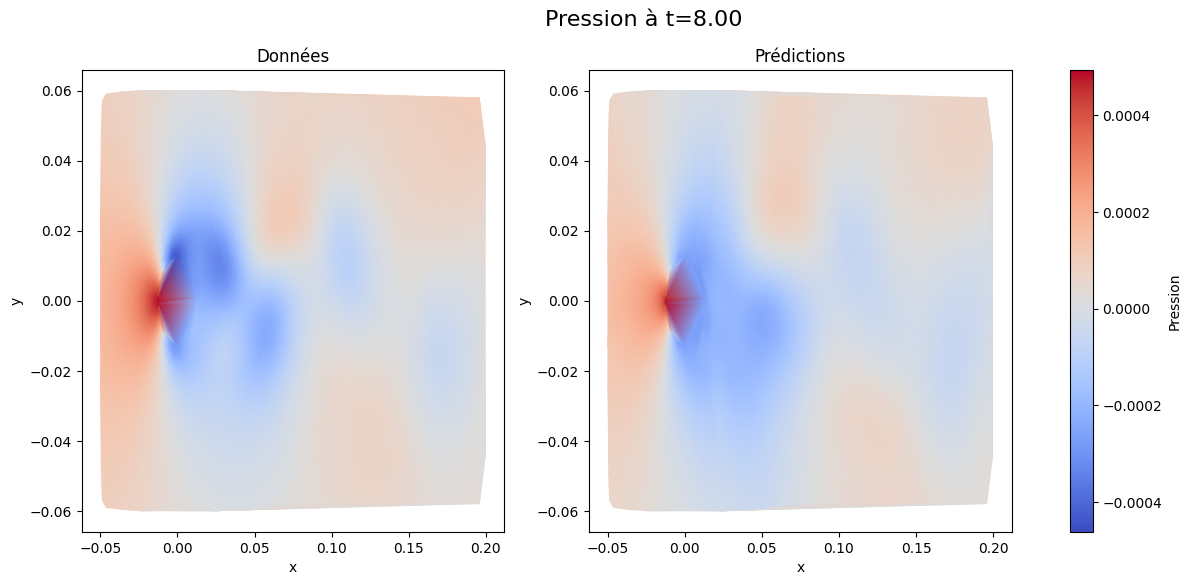

In [10]:
plot_flow(x_pred, y_pred, t_pred, norme_vitesse_data, norme_vitesse_pred, name_file= 'result_pression.gif', title='Pression', fps=5)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

def plot_flow_unique(x, y, t, norme_vitesse_data, norme_vitesse_predict, name_file, fps=7, title='Norme vitesse'):
    # Créer une figure et des axes
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))  # Ajuster la taille de la figure

    # Déterminer les valeurs min et max pour la colormap
    vmin = np.min(norme_vitesse_data)#, np.min(norme_vitesse_predict))
    vmax = np.max(norme_vitesse_data)#, np.max(norme_vitesse_predict))

    # Initialiser les cartes de chaleur
    indices = np.where(t == np.min(t))
    c1 = ax.tripcolor(x[indices],
            y[indices],
            norme_vitesse_data[indices], shading="gouraud", cmap="coolwarm", vmin=vmin, vmax=vmax)
    # c2 = ax[1].tripcolor(x[indices],
    #         y[indices],
    #         norme_vitesse_predict[indices], shading="gouraud", cmap="coolwarm", vmin=vmin, vmax=vmax)

    ax.set_title('Données')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    # ax[1].set_title('Prédictions')
    # ax[1].set_xlabel("x")
    # ax[1].set_ylabel("y")

    # Ajouter une barre de couleur
    cbar = fig.colorbar(c1, ax=ax, orientation='vertical', label=f"{title}")

    # Fonction d'initialisation
    def init():
        return c1 #, c2

    # Fonction d'animation
    def update(frame):
        print(frame)
        time = list(set(t))
        time.sort()
        indices = np.where(t == time[frame])
        
        # Mettre à jour la première carte de chaleur
        c1.set_array(norme_vitesse_data[indices].flatten())
        ax.set_title('Données')
        
        # # Mettre à jour la deuxième carte de chaleur
        # c2.set_array(norme_vitesse_predict[indices].flatten())
        # ax[1].set_title('Prédictions')

        # Titre général
        plt.suptitle(f"{title} à t={time[frame]:.2f}", fontsize=16)

        return c1#, c2

    # Créer l'animation
    ani = FuncAnimation(fig, update, frames=len(set(t)), init_func=init, blit=False, repeat=True)
    ani.save(name_file, writer="pillow", fps=fps)

    plt.show()  # Afficher la figure à la fin

# Exemple d'utilisation
# plot_flow(x, y, t, norme_vitesse_data, norme_vitesse_predict, 'animation.gif')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203


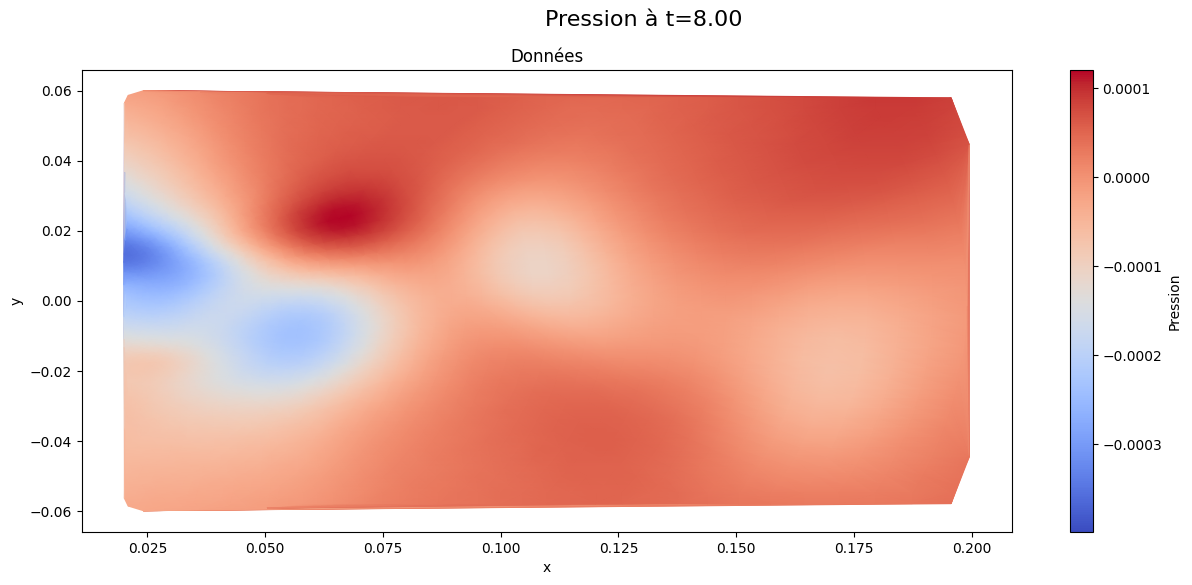

In [18]:
plot_flow_unique(x_pred, y_pred, t_pred, p_pred, p_data, name_file= 'result_pression3.gif', title='Pression', fps=5)

In [ ]:
from animate import anim

In [19]:
x_full = (X_full[:,0]*mean_std['x_std'] + mean_std['x_mean'])*param_adim['L']
y_full = (X_full[:,1]*mean_std['y_std'] + mean_std['y_mean'])*param_adim['L']
t_full = (X_full[:,2]*mean_std['t_std'] + mean_std['t_mean'])*(param_adim['L']/param_adim['V'])
u_full = (U_full[:,0]*mean_std['u_std'] + mean_std['u_mean'])*param_adim['V']
v_full = (U_full[:,1]*mean_std['v_std'] + mean_std['v_mean'])*param_adim['V']
p_full = (U_full[:,2]*mean_std['p_std'] + mean_std['p_mean'])*((param_adim['L']**2) * param_adim['rho'])

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
0


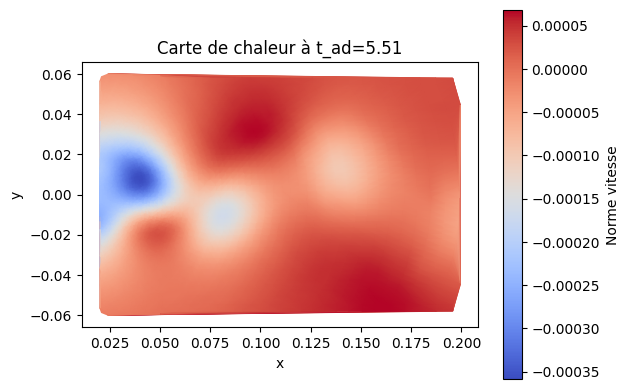

In [26]:
anim('piche2.gif', x_full, y_full, t_full, p_full, fps=5)

In [27]:
x_pred == x_full

array([ True,  True,  True, ...,  True,  True,  True])